In [1]:
import cvxpy as cp
import polars as pl
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from datetime import datetime
import datetime as timedelta
import random

pd.set_option('display.max_colwidth', 200)
pd.options.display.float_format = '{:.10f}'.format
path = path = '../LinearProgram/DebtOutstanding.csv'


In [2]:
data = pd.read_csv(path)
del data['CPN2']
data.head()


,Outstanding,Maturity Date,Fixed / Float,Local / International,CPN,ATM
0,333333333,29-Jun-2024,1,1,0.0284000000,0.5000000000
1,714272727,29-Jun-2024,1,1,0.0277000000,0.5000000000
2,423076923,29-Jun-2024,1,1,0.0325000000,0.5000000000
3,454000000,27-Jul-2024,1,1,0.0245000000,0.5700000000
4,1090000000,28-Jul-2024,1,1,0.0251000000,0.5800000000


In [3]:
def plotting(result):
    
    plt.plot(result ,color= 'blue',marker='o' )
    plt.ylim(10-100, 100+100)
    plt.ylabel('Outstanding (bn)')
    plt.title('')
    plt.xlabel('years')
    plt.show()
    
def total_optimized_outstanding(result):
    
    result = result.groupby('Maturity Date').agg('optimized_outstanding').sum()
    Maturity_Dates= data[['Outstanding','Maturity Date']].copy()
    Maturity_Dates['Maturity Date'] = Maturity_Dates['Maturity Date'].str[-4:]
    Agg_current_outstaningd = (Maturity_Dates.groupby('Maturity Date').agg('Outstanding').sum())
    Agg_current_outstaningd= Agg_current_outstaningd/1e9
    for i in range(len(Agg_current_outstaningd)):
        result.iloc[i] = result.iloc[i] + Agg_current_outstaningd[i]
    
    return plotting(result)
    

In [4]:
def time_to_maturity(maturity_dates):
     list_md=[]
     for i in range(len(maturity_dates)):
         list_md.append((maturity_dates[i] - 2023)/365) 
     return list_md

In [5]:
def optimizer(data, input_data , num_security , interests , years , type , L_or_I, time_maturity):
    # Get Current outstanding (total, floating-rate, foreign currency)
    current_outstanding = (910662741931+data['Outstanding'].sum()) / 1e9
    floating = (data[data['Fixed / Float'] == 0]['Outstanding'].sum()) / 1e9
    foreign = (197764126034 + data[data['Local / International'] == 0]['Outstanding'].sum() ) / 1e9

    # Get the indices
    local_indices = np.where(input_data['Local / International'] == 1)[0]
    international_indices = np.where(input_data['Local / International'] == 0)[0]
    float_indices = np.where(input_data['Fixed / Float'] == 0)[0]
  
    # Group the current portfolio based on years
    Maturity_Dates = data[['Outstanding','Maturity Date']].copy()
    Maturity_Dates['Maturity Date'] = Maturity_Dates['Maturity Date'].str[-4:]
    Agg_current_outstaningd = (Maturity_Dates.groupby('Maturity Date').agg('Outstanding').sum())
    Agg_current_outstaningd = Agg_current_outstaningd / 1e9
    Today = 2023
    

    # Decision Variables 
    outstanding = cp.Variable(num_security, nonneg=True)

    #Objective Function
    cost = outstanding @ interests
    objective = cp.Minimize(cost)
    Portfolio = cp.sum(outstanding) + current_outstanding
    
    # Constraints 
    constraints = []

    #Constraint 1, set the total optimized outstanding  to be 200bn or greater
    constraints.append( ( cp.sum(outstanding)) >= 200 )
    
    # Constraint 2, IR Risk
    constraints.append( ( cp.sum(outstanding[float_indices]) + floating ) <= 0.2 * Portfolio )

    # Constraint 3, FX Risk
    usd_outstanding = cp.sum(outstanding[international_indices]) 
    constraints.append( ( usd_outstanding + foreign) >=  0.3  * Portfolio   )
    constraints.append( ( usd_outstanding + foreign ) <=  0.5  * Portfolio   )
    
    # Constraint 4, Smoothing Years , the outstanding should be smoothed with respect to the current portfolio and the optimized for each year combined
    e = 0.1  # ebsilon
    for i in range(num_security):
        p_i = outstanding[i] + Agg_current_outstaningd[i]
        p_i_1 = outstanding[i%(num_security-1)+1] + Agg_current_outstaningd[i%(num_security-1)+1]
        constraints.append( (p_i) <= ((1+e)*p_i_1) )
        constraints.append( (p_i) >= ((1-e)*p_i_1) )

    # Constraint 5, ATM
        ATM_international = (outstanding[international_indices] @ time_maturity[international_indices]) / cp.sum(outstanding[international_indices])
        constraints.append(ATM_international + 9.5 >= 7.5)
        constraints.append(ATM_international + 9.5 <= 10.5)

        ATM_local = (outstanding[local_indices] @ time_maturity[local_indices]) / cp.sum(outstanding[local_indices])
        constraints.append(ATM_local + 9.5 >= 7.5)
        constraints.append(ATM_local + 9.5 <= 10.5)

        
        

    # Solve 
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.ECOS , qcp=True )

    #printing
    for i in range(len(input_data)):
        input_data['optimized_outstanding'].iloc[i]=outstanding.value[i] 
    return  input_data


/var/folders/f8/n9fgmqnn6xx60zp5yj4d5yrr0000gp/T/ipykernel_48264/1022417630.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['optimized_outstanding'].iloc[i]=outstanding.value[i]


,optimized_outstanding,Interest Rate,Local / International,Fixed / Float,Maturity Date
0,67.4069450068,0.0217576337,1,1,2024
1,29.2485796025,0.0287706374,1,1,2025
2,43.3444741272,0.0323433079,1,1,2026
3,38.0518556485,0.0423408935,0,0,2027
4,21.9481459057,0.0522832669,0,1,2028


Optimized Outstanding :  200.00000029070932


Outstanding Per Year : 


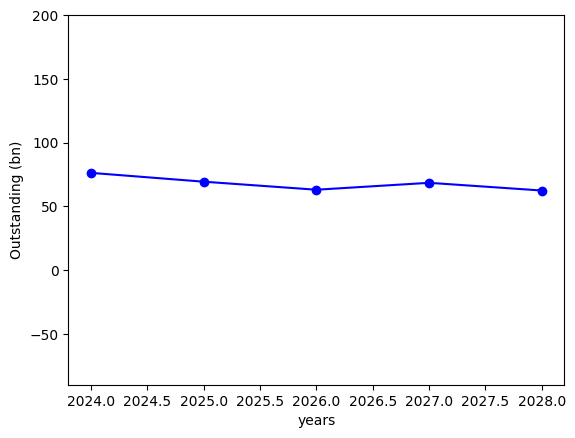

In [6]:
for k in range(1):
  random_list = [random.uniform(0.015, 0.0325) for _ in range(5)]
  random_FX = [random.uniform(0.035, 0.055) for _ in range(2)]
  random_list[4] = random_FX[0]
  random_list[3] = random_FX[1]
 

  
   # input data 
  input_data = pd.DataFrame({
    'optimized_outstanding'   :[0,0,0,0,0],
    'Interest Rate'           :random_list,
    'Local / International'    :[1,1,1,0,0] ,
    'Fixed / Float'           :[1,1,1,0,1],
    'Maturity Date'           :[2024 ,2025 ,2026 ,2027 ,2028],
   
 
})

  result = optimizer( data,
                   input_data,
                     len(input_data),
                       np.array(input_data['Interest Rate']),
                         np.array(input_data['Maturity Date']),
                           np.array(input_data['Fixed / Float']),
                             np.array(input_data['Local / International']),
                             np.array(time_to_maturity(np.array(input_data['Maturity Date'])))
                              
                              )

  display(result)
  print('Optimized Outstanding : ',result['optimized_outstanding'].sum())
  print('\n')
  print('Outstanding Per Year : ')
  total_optimized_outstanding(result)
  